In [1]:
%matplotlib inline 

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, trades, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union
from pathlib import Path
import time

import torch
import torch.nn as nn
from torch.nn import MSELoss, Dropout
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR
from torch.amp import GradScaler

from tqdm import tqdm

from copy import deepcopy
from typing import Callable, List, Dict, Tuple, Optional

import shap
from captum.attr import IntegratedGradients

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.preprocessing import StandardScaler

from IPython.display import clear_output, display

In [3]:
# Load full feature set filter to regular trading hours

df_all_features = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True).between_time(params.sess_start, params.sess_end)

# Separate feature matrix X and target vector y
all_features = [c for c in df_all_features.columns if c not in ['close_raw', params.label_col]]
X_all        = df_all_features[all_features]
y            = df_all_features[params.label_col]

print(all_features)

['volume', 'ret', 'log_ret', 'roc_14', 'body', 'body_pct', 'upper_shad', 'lower_shad', 'range_pct', 'rsi_14', 'macd_line_12_26_9', 'macd_signal_12_26_9', 'macd_diff_12_26_9', 'sma_pct_14', 'sma_pct_28', 'atr_14', 'atr_pct_14', 'bb_w_20', 'plus_di_14', 'minus_di_14', 'adx_14', 'obv', 'obv_diff_14', 'obv_pct_14', 'obv_sma_14', 'vol_spike_14', 'hour', 'day_of_week', 'month', 'eng_ma', 'eng_macd', 'eng_bb', 'eng_bb_mid', 'eng_rsi', 'eng_adx', 'eng_obv', 'eng_atr_div', 'eng_sma_short', 'eng_sma_long', 'eng_vwap']


Dropped low-variance features: []
Dropped high-correlation features: ['log_ret']
Kept after std filter (count): 40
Kept after correlation pruning (count): 39


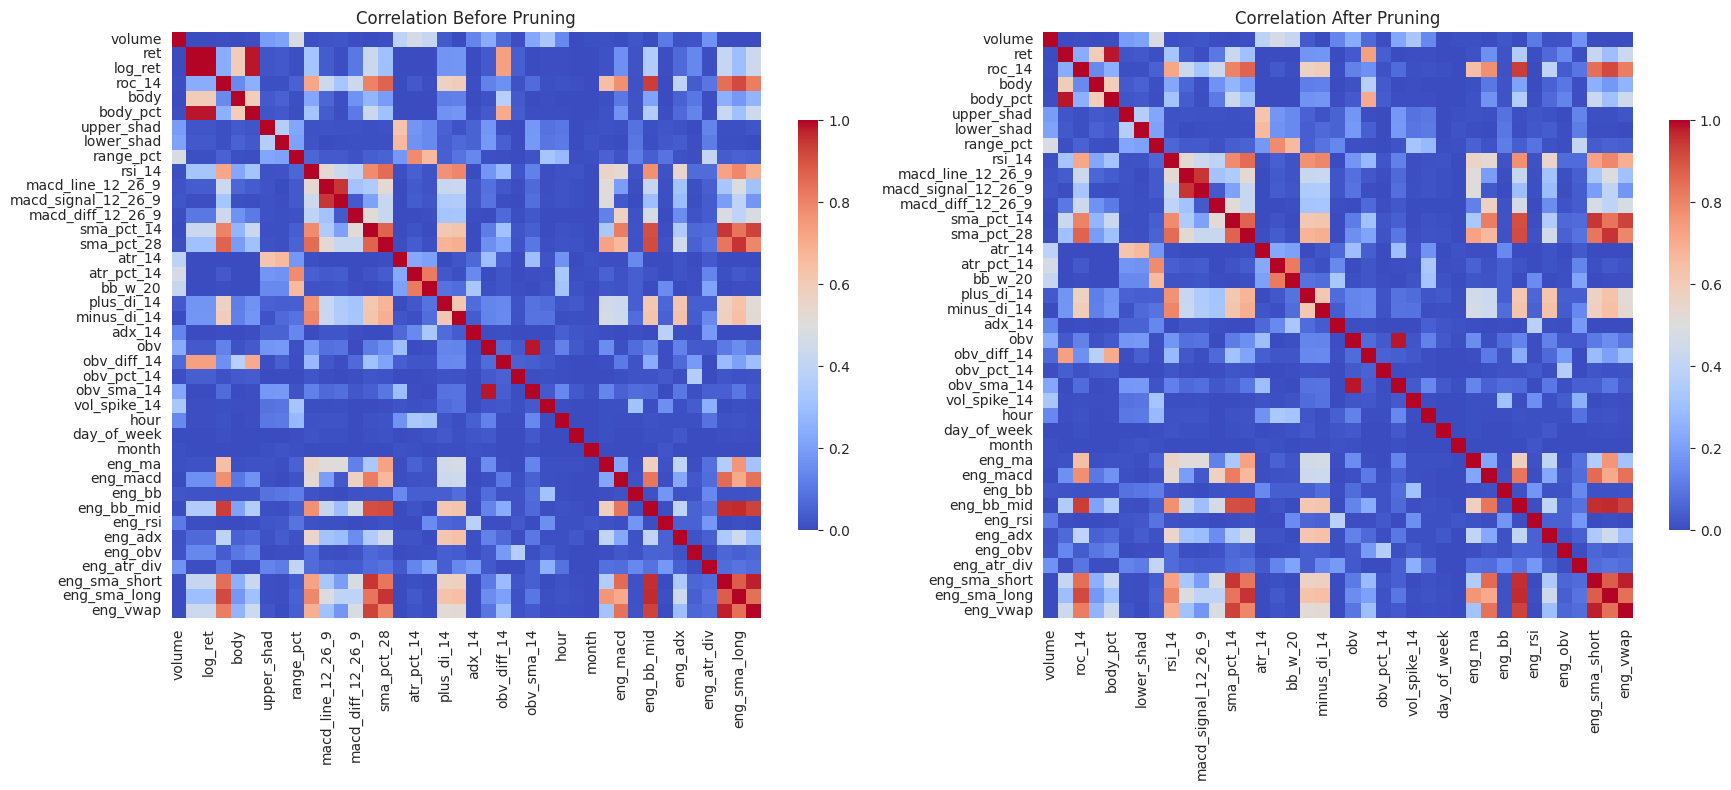

In [4]:
importlib.reload(params) #########

kept_after_std, pruned_feats, corr_full, corr_pruned = feats.prune_features_by_variance_and_correlation(
    X_all=X_all,
    y=y,
    min_std=params.feats_min_std,
    max_corr=params.feats_max_corr
)

# show heatmaps
feats.plot_correlation_before_after(corr_full, corr_pruned)

In [5]:
# build final feature DataFrame if needed
df_feat_prun = df_all_features[pruned_feats + [params.label_col] + ['close_raw']]

df_feat_prun

,volume,ret,roc_14,body,body_pct,upper_shad,lower_shad,range_pct,rsi_14,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,sma_pct_14,sma_pct_28,atr_14,atr_pct_14,bb_w_20,plus_di_14,minus_di_14,adx_14,obv,obv_diff_14,obv_pct_14,obv_sma_14,vol_spike_14,hour,day_of_week,month,eng_ma,eng_macd,eng_bb,eng_bb_mid,eng_rsi,eng_adx,eng_obv,eng_atr_div,eng_sma_short,eng_sma_long,eng_vwap,signal,close_raw
2004-01-02 14:30:00,1.000000,0.811219,0.567035,0.513912,1.000000,0.000637,0.000490,1.000000,0.990316,0.494836,0.487555,0.510680,1.000000,1.000000,0.002158,0.273678,0.878114,0.405934,0.136242,0.835045,0.000000,1.000000,0.419491,0.000000,0.682133,0.201260,-0.977218,-0.123092,0.576587,0.651393,0.000000,0.416749,0.967721,0.625294,0.00000,1.000000,0.457593,0.358549,0.378022,0.463747,0.772500
2004-01-02 14:31:00,0.455158,0.810787,0.569880,0.516678,1.000000,0.000955,0.000490,1.000000,0.992008,0.495319,0.487917,0.511192,1.000000,1.000000,0.002996,0.379408,0.921733,0.359820,0.091129,0.817958,0.000000,1.000000,0.453105,0.000000,0.427762,0.201260,-0.977218,-0.123092,0.580315,0.654786,0.002220,0.412417,0.973361,0.622091,0.00000,1.000000,0.453248,0.353382,0.373958,0.423777,0.773571
2004-01-02 14:32:00,0.931212,1.000000,0.582226,0.514465,1.000000,0.000000,0.001665,1.000000,0.994892,0.496334,0.488428,0.513046,1.000000,1.000000,0.003575,0.450939,1.000000,0.390934,0.070902,0.809030,0.000000,1.000000,0.394723,0.000000,0.553429,0.201260,-0.977218,-0.123092,0.585990,0.667051,0.030718,0.392787,0.982973,0.639760,0.00000,1.000000,0.433213,0.333213,0.358221,0.380621,0.776786
2004-01-02 14:33:00,0.213437,0.396830,0.578720,0.506538,0.499412,0.000318,0.001959,0.500105,0.953715,0.496974,0.488977,0.513511,1.000000,1.000000,0.003650,0.460644,1.000000,0.355525,0.064480,0.800738,0.000000,0.110604,0.531049,0.000000,0.213555,0.201260,-0.977218,-0.123092,0.590625,0.670097,0.006202,0.400129,0.845716,0.627483,0.96159,1.000000,0.441553,0.339378,0.363712,0.333847,0.776429
2004-01-02 14:34:00,0.273285,0.087460,0.570460,0.502851,0.163166,0.000318,0.000000,0.501027,0.809406,0.497078,0.489439,0.512430,1.000000,1.000000,0.003720,0.470330,1.000000,0.323928,0.058750,0.793040,0.000000,0.018838,0.536756,0.000000,0.244383,0.201260,-0.977218,-0.123092,0.593331,0.662931,0.000000,0.414831,0.364687,0.616707,1.00000,1.000000,0.457317,0.353030,0.377330,0.283178,0.775000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.362651,0.642346,0.550037,0.854984,0.624850,0.039242,0.066943,0.254109,0.672166,0.971125,0.885657,0.888941,0.751690,0.747005,0.580814,0.323886,0.273759,0.363125,0.074852,0.301944,0.333024,1.000000,0.536512,0.277723,0.358865,-0.975989,0.024469,0.605122,0.532431,0.634772,0.883846,0.438387,0.000000,0.537709,1.00000,0.664288,0.472166,0.385641,0.387389,0.165471,196.815000
2025-06-18 20:57:00,0.434283,0.340442,0.544953,0.158091,0.374057,0.108960,0.149355,0.420131,0.616686,0.981544,0.912555,0.840741,0.650094,0.674116,0.599850,0.336016,0.290460,0.347207,0.067044,0.328685,0.306009,0.000000,0.456298,0.281582,0.375525,-0.975989,0.024469,0.605122,0.532016,0.633511,0.000000,0.443128,0.000000,0.541855,0.00000,0.676887,0.477491,0.390647,0.392906,0.148438,196.675000
2025-06-18 20:58:00,0.496049,0.494192,0.543637,0.493632,0.494766,0.056143,0.053813,0.121620,0.614734,0.983006,0.934392,0.777896,0.631153,0.659095,0.577674,0.322169,0.304199,0.336272,0.064933,0.353515,0.275205,0.000000,0.444697,0.282714,0.380516,-0.975989,0.024469,0.605122,0.531618,0.631866,0.000000,0.443870,0.000000,0.545337,0.00000,0.584662,0.478481,0.391677,0.393782,0.147712,196.670000
2025-06-18 20:59:00,1.000000,0.009795,0.538028,0.000000,0.090577,0.060319,0.000000,0.565110,0.475401,0.884486,0.930352,0.456523,0.375519,0.478307,0.616017,0.346959,0.305249,0.290578,0.160021,0.348960,0.153481,0.000000,0.253560,0.275289,0.650190,-0.975989,0.024469,0.605122,0.531157,0.623450,0.000000,0.4562

In [6]:
train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df             = df_feat_prun,
    look_back      = params.hparams["LOOK_BACK"],
    sess_start     = params.sess_start_pred_tick,
    train_prop     = params.train_prop,
    val_prop       = params.val_prop,
    train_batch    = params.hparams["TRAIN_BATCH"],
    train_workers  = params.hparams["TRAIN_WORKERS"],
    prefetch_factor= params.hparams["TRAIN_PREFETCH_FACTOR"],
    signal_thresh  = params.best_optuna_params["buy_threshold"],
    return_thresh  = params.return_threshold_tick
)

for name, ld, tm in zip(
    ["train","val","test"],
    [train_loader, val_loader, test_loader],
    [end_times_tr, end_times_val, end_times_te]
):
    models_core.summarize_split(name, ld, tm)

Inside build_tensors, features: ['volume', 'ret', 'roc_14', 'body', 'body_pct', 'upper_shad', 'lower_shad', 'range_pct', 'rsi_14', 'macd_line_12_26_9', 'macd_signal_12_26_9', 'macd_diff_12_26_9', 'sma_pct_14', 'sma_pct_28', 'atr_14', 'atr_pct_14', 'bb_w_20', 'plus_di_14', 'minus_di_14', 'adx_14', 'obv', 'obv_diff_14', 'obv_pct_14', 'obv_sma_14', 'vol_spike_14', 'hour', 'day_of_week', 'month', 'eng_ma', 'eng_macd', 'eng_bb', 'eng_bb_mid', 'eng_rsi', 'eng_adx', 'eng_obv', 'eng_atr_div', 'eng_sma_short', 'eng_sma_long', 'eng_vwap']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

--- TRAIN ---
 calendar days : 3792  (2004-01-02 → 2019-01-25)
 windows       : 1258944  (per-day min=332, max=332, mean=332.0)
 window shape  : look_back=60, n_features=39
 dataloader    : batches=237, batch_size=16, workers=8, pin_memory=True

--- VAL ---
 calendar days : 799  (2019-01-28 → 2022-03-28)
 windows       : 265268  (per-day min=332, max=332, mean=332.0)
 window shape  : look_back=60, n_features=39
 dataloader    : batches=799, batch_size=1, workers=0, pin_memory=True

--- TEST ---
 calendar days : 809  (2022-03-29 → 2025-06-18)
 windows       : 268588  (per-day min=332, max=332, mean=332.0)
 window shape  : look_back=60, n_features=39
 dataloader    : batches=809, batch_size=1, workers=0, pin_memory=True



In [7]:
# importlib.reload(models_custom) #############

# -----------------------------------------------------------------------------
# Instantiate the ModelClass & move to device
# -----------------------------------------------------------------------------

model = models_custom.ModelClass(
    n_feats             = len(pruned_feats),
    short_units         = params.hparams["SHORT_UNITS"],
    long_units          = params.hparams["LONG_UNITS"],
    transformer_d_model = 64,
    transformer_layers  = 1,
    dropout_short       = params.hparams["DROPOUT_SHORT"],
    dropout_long        = params.hparams["DROPOUT_LONG"],
    dropout_trans       = params.hparams["DROPOUT_TRANS"],
    pred_hidden         = params.hparams["PRED_HIDDEN"],
    window_len          = params.hparams["LOOK_BACK"],

    # Gating flags
    use_conv            = False,
    use_tcn             = False,
    use_short_lstm      = False,
    use_transformer     = True,
    use_long_lstm       = False,
    use_delta           = False,
    flatten_mode        = params.hparams["FLATTEN_MODE"]
)

model.to(params.device)  
    
model

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:375: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ModelClass(
  (conv): Identity()
  (bn): Identity()
  (relu): ReLU()
  (tcn): Identity()
  (ln_short): Identity()
  (do_short): Identity()
  (feature_proj): Linear(in_features=39, out_features=64, bias=True)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (short2long

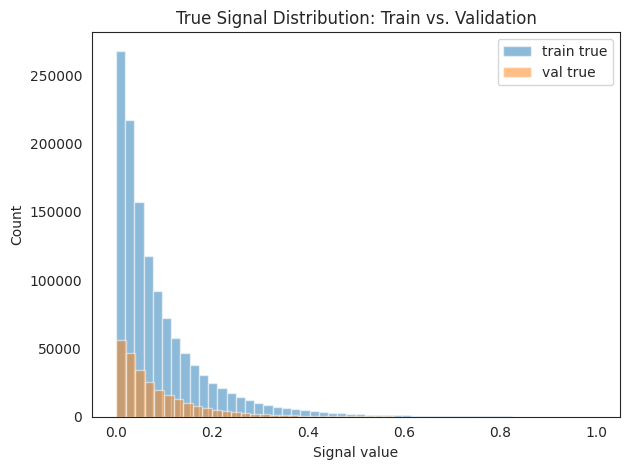

In [8]:
y_train = np.concatenate([batch[1].cpu().numpy().ravel() for batch in train_loader])
y_val = np.concatenate([batch[1].cpu().numpy().ravel() for batch in val_loader])

# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=50, alpha=0.5, label="train true")
plt.hist(y_val,   bins=50, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
optimizer = AdamW(
  model.parameters(),
  lr           = params.hparams["ONECYCLE_MAX_LR"],
  weight_decay = params.hparams["WEIGHT_DECAY"]
)

batches_per_epoch = len(train_loader)
total_steps = batches_per_epoch * params.hparams["MAX_EPOCHS"]

scheduler = OneCycleLR(
  optimizer,
  max_lr           = 1.5e-4,
  total_steps      = total_steps,
  pct_start        = params.hparams["ONECYCLE_PCT_START"],
  div_factor       = params.hparams["ONECYCLE_DIV_FACTOR"],
  final_div_factor = params.hparams["ONECYCLE_FINAL_DIV"],
  anneal_strategy  = params.hparams["ONECYCLE_STRATEGY"],
)
optimizer.scheduler = scheduler # necessary to log sched_field

if getattr(scheduler, "total_steps", None) != total_steps:
    raise RuntimeError(f"Scheduler total_steps mismatch: scheduler={getattr(scheduler,'total_steps',None)} expected={total_steps}")

scheduler

Training sees 3792 unique trading days per epoch.

Model parameters: total=78,275, trainable=78,275

Using HyperParameters:
 {'USE_CONV': False, 'CONV_K': 3, 'CONV_DILATION': 1, 'CONV_CHANNELS': 64, 'USE_TCN': False, 'TCN_LAYERS': 2, 'TCN_KERNEL': 3, 'TCN_CHANNELS': 64, 'USE_SHORT_LSTM': False, 'SHORT_UNITS': 128, 'DROPOUT_SHORT': 0.1, 'USE_TRANSFORMER': True, 'TRANSFORMER_D_MODEL': 128, 'TRANSFORMER_LAYERS': 3, 'TRANSFORMER_HEADS': 4, 'TRANSFORMER_FF_MULT': 4, 'DROPOUT_TRANS': 0.1, 'USE_LONG_LSTM': False, 'DROPOUT_LONG': 0.1, 'LONG_UNITS': 128, 'FLATTEN_MODE': 'pool', 'PRED_HIDDEN': 128, 'ALPHA_SMOOTH': 0.0, 'WARMUP_STEPS': 5, 'USE_HUBER': False, 'HUBER_DELTA': 0.1, 'USE_DELTA': False, 'LAMBDA_DELTA': 0.1, 'MAX_EPOCHS': 70, 'EARLY_STOP_PATIENCE': 7, 'WEIGHT_DECAY': 1e-05, 'CLIPNORM': 3, 'ONECYCLE_MAX_LR': 0.0005, 'ONECYCLE_DIV_FACTOR': 10, 'ONECYCLE_FINAL_DIV': 100, 'ONECYCLE_PCT_START': 0.1, 'ONECYCLE_STRATEGY': 'cos', 'TRAIN_BATCH': 16, 'VAL_BATCH': 1, 'TRAIN_WORKERS': 8, 'TRAIN_PRE

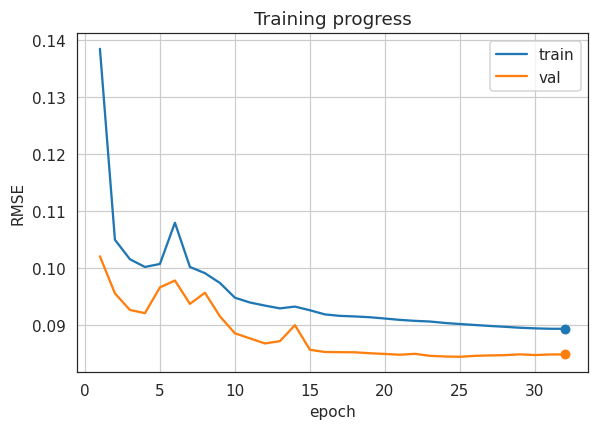

Epoch 1 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 01  TRAIN→ RMSE=0.13847, R²=-0.746 |  VALID→ RMSE=0.10207, R²=-0.073 |  lr=2.17e-05 |  loss=1.91748e-02 |  improved=True


Epoch 2 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 02  TRAIN→ RMSE=0.10497, R²=-0.003 |  VALID→ RMSE=0.09556, R²=0.060 |  lr=4.04e-05 |  loss=1.10181e-02 |  improved=True


Epoch 3 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 03  TRAIN→ RMSE=0.10155, R²=0.061 |  VALID→ RMSE=0.09265, R²=0.116 |  lr=6.75e-05 |  loss=1.03116e-02 |  improved=True


Epoch 4 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 04  TRAIN→ RMSE=0.10020, R²=0.086 |  VALID→ RMSE=0.09209, R²=0.127 |  lr=9.76e-05 |  loss=1.00397e-02 |  improved=True


Epoch 5 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 05  TRAIN→ RMSE=0.10072, R²=0.076 |  VALID→ RMSE=0.09662, R²=0.039 |  lr=1.25e-04 |  loss=1.01455e-02 |  improved=False


Epoch 6 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 06  TRAIN→ RMSE=0.10796, R²=-0.061 |  VALID→ RMSE=0.09781, R²=0.015 |  lr=1.43e-04 |  loss=1.16548e-02 |  improved=False


Epoch 7 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 07  TRAIN→ RMSE=0.10019, R²=0.086 |  VALID→ RMSE=0.09372, R²=0.096 |  lr=1.50e-04 |  loss=1.00384e-02 |  improved=False


Epoch 8 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 08  TRAIN→ RMSE=0.09911, R²=0.105 |  VALID→ RMSE=0.09567, R²=0.058 |  lr=1.50e-04 |  loss=9.82265e-03 |  improved=False


Epoch 9 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 09  TRAIN→ RMSE=0.09739, R²=0.136 |  VALID→ RMSE=0.09153, R²=0.137 |  lr=1.50e-04 |  loss=9.48463e-03 |  improved=True


Epoch 10 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 10  TRAIN→ RMSE=0.09480, R²=0.182 |  VALID→ RMSE=0.08855, R²=0.193 |  lr=1.49e-04 |  loss=8.98686e-03 |  improved=True


Epoch 11 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 11  TRAIN→ RMSE=0.09396, R²=0.196 |  VALID→ RMSE=0.08767, R²=0.209 |  lr=1.49e-04 |  loss=8.82862e-03 |  improved=True


Epoch 12 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 12  TRAIN→ RMSE=0.09342, R²=0.205 |  VALID→ RMSE=0.08678, R²=0.225 |  lr=1.48e-04 |  loss=8.72685e-03 |  improved=True


Epoch 13 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 13  TRAIN→ RMSE=0.09293, R²=0.213 |  VALID→ RMSE=0.08718, R²=0.217 |  lr=1.47e-04 |  loss=8.63609e-03 |  improved=False


Epoch 14 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 14  TRAIN→ RMSE=0.09324, R²=0.208 |  VALID→ RMSE=0.08998, R²=0.166 |  lr=1.45e-04 |  loss=8.69406e-03 |  improved=False


Epoch 15 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 15  TRAIN→ RMSE=0.09260, R²=0.219 |  VALID→ RMSE=0.08567, R²=0.244 |  lr=1.44e-04 |  loss=8.57488e-03 |  improved=True


Epoch 16 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 16  TRAIN→ RMSE=0.09187, R²=0.231 |  VALID→ RMSE=0.08528, R²=0.251 |  lr=1.43e-04 |  loss=8.44034e-03 |  improved=True


Epoch 17 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 17  TRAIN→ RMSE=0.09162, R²=0.236 |  VALID→ RMSE=0.08525, R²=0.252 |  lr=1.41e-04 |  loss=8.39343e-03 |  improved=True


Epoch 18 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 18  TRAIN→ RMSE=0.09151, R²=0.237 |  VALID→ RMSE=0.08522, R²=0.252 |  lr=1.39e-04 |  loss=8.37487e-03 |  improved=True


Epoch 19 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 19  TRAIN→ RMSE=0.09137, R²=0.240 |  VALID→ RMSE=0.08506, R²=0.255 |  lr=1.37e-04 |  loss=8.34912e-03 |  improved=True


Epoch 20 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 20  TRAIN→ RMSE=0.09115, R²=0.243 |  VALID→ RMSE=0.08493, R²=0.257 |  lr=1.35e-04 |  loss=8.30819e-03 |  improved=True


Epoch 21 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 21  TRAIN→ RMSE=0.09091, R²=0.247 |  VALID→ RMSE=0.08480, R²=0.260 |  lr=1.32e-04 |  loss=8.26471e-03 |  improved=True


Epoch 22 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 22  TRAIN→ RMSE=0.09074, R²=0.250 |  VALID→ RMSE=0.08495, R²=0.257 |  lr=1.30e-04 |  loss=8.23358e-03 |  improved=False


Epoch 23 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 23  TRAIN→ RMSE=0.09063, R²=0.252 |  VALID→ RMSE=0.08461, R²=0.263 |  lr=1.27e-04 |  loss=8.21290e-03 |  improved=True


Epoch 24 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 24  TRAIN→ RMSE=0.09037, R²=0.256 |  VALID→ RMSE=0.08449, R²=0.265 |  lr=1.25e-04 |  loss=8.16701e-03 |  improved=True


Epoch 25 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 25  TRAIN→ RMSE=0.09019, R²=0.259 |  VALID→ RMSE=0.08444, R²=0.266 |  lr=1.22e-04 |  loss=8.13334e-03 |  improved=True


Epoch 26 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 26  TRAIN→ RMSE=0.09002, R²=0.262 |  VALID→ RMSE=0.08460, R²=0.263 |  lr=1.19e-04 |  loss=8.10284e-03 |  improved=False


Epoch 27 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 27  TRAIN→ RMSE=0.08984, R²=0.265 |  VALID→ RMSE=0.08468, R²=0.262 |  lr=1.16e-04 |  loss=8.07193e-03 |  improved=False


Epoch 28 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 28  TRAIN→ RMSE=0.08970, R²=0.267 |  VALID→ RMSE=0.08472, R²=0.261 |  lr=1.13e-04 |  loss=8.04561e-03 |  improved=False


Epoch 29 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 29  TRAIN→ RMSE=0.08953, R²=0.270 |  VALID→ RMSE=0.08486, R²=0.259 |  lr=1.09e-04 |  loss=8.01622e-03 |  improved=False


Epoch 30 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 30  TRAIN→ RMSE=0.08943, R²=0.272 |  VALID→ RMSE=0.08474, R²=0.261 |  lr=1.06e-04 |  loss=7.99704e-03 |  improved=False


Epoch 31 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 31  TRAIN→ RMSE=0.08935, R²=0.273 |  VALID→ RMSE=0.08484, R²=0.259 |  lr=1.02e-04 |  loss=7.98382e-03 |  improved=False


Epoch 32 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 32  TRAIN→ RMSE=0.08935, R²=0.273 |  VALID→ RMSE=0.08485, R²=0.259 |  lr=9.89e-05 |  loss=7.98297e-03 |  improved=False
✅ Final‐best model saved: AAPL_0.08444_fin.pth


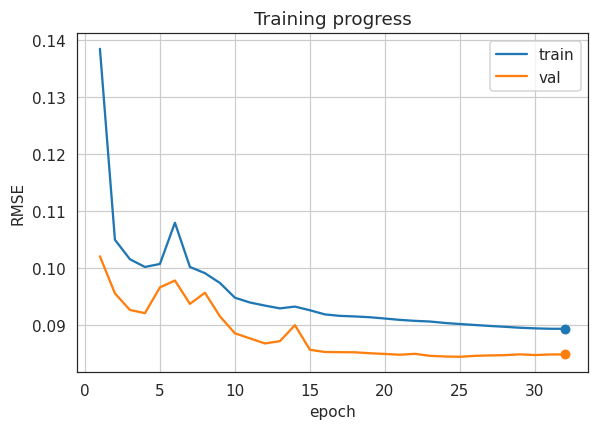

In [10]:
importlib.reload(params) #############
importlib.reload(models_custom) #############
importlib.reload(models_core) #############

n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: total={total_params:,}, trainable={trainable_params:,}\n")

print('Using HyperParameters:\n', params.hparams)

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models_custom.model_training_loop(
    model               = model,
    optimizer           = optimizer,
    scheduler           = scheduler,
    scaler              = GradScaler(),
    train_loader        = train_loader,
    val_loader          = val_loader,
)


In [11]:
# retrieve model just trained (keep exactly 5 decimals)
fname = f"{params.ticker}_{best_val_rmse:.5f}_fin.pth"
chk = Path(params.models_folder) / fname

# load checkpoint and recreate model from stored hparams
ckpt = torch.load(chk, map_location="cpu", weights_only=False)
h = ckpt["hparams"]

# load weights, move to device, set eval
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

print("Loaded checkpoint:", chk)

Loaded checkpoint: trainings/AAPL_0.08444_fin.pth


In [12]:
# df_test creation not strictly necessary for the feature importance calculation

print('Calculating Train metrics and predictions...')
_, _, train_preds, _, _ = \
    models_custom.eval_on_loader(train_loader, model)

print('Calculating Val metrics and predictions...')
_, _, val_preds, _, _  = \
    models_custom.eval_on_loader(val_loader,   model)

print('Calculating Test metrics and predictions...')
_, _, test_preds, _, _ = \
    models_custom.eval_on_loader(test_loader,  model)

print('Adding the predictions to df_test...')
_, df_test = models_custom.add_preds_and_split(
    df            = df_feat_prun,
    train_preds   = train_preds,
    val_preds     = val_preds,
    test_preds    = test_preds,
    end_times_tr  = end_times_tr,
    end_times_val = end_times_val,
    end_times_te  = end_times_te
)

df_test

Calculating Train metrics and predictions...


eval:   0%|          | 0/237 [00:00<?, ?it/s]

Calculating Val metrics and predictions...


eval:   0%|          | 0/799 [00:00<?, ?it/s]

Calculating Test metrics and predictions...


eval:   0%|          | 0/809 [00:00<?, ?it/s]

Adding the predictions to df_test...


,volume,ret,roc_14,body,body_pct,upper_shad,lower_shad,range_pct,rsi_14,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,sma_pct_14,sma_pct_28,atr_14,atr_pct_14,bb_w_20,plus_di_14,minus_di_14,adx_14,obv,obv_diff_14,obv_pct_14,obv_sma_14,vol_spike_14,hour,day_of_week,month,eng_ma,eng_macd,eng_bb,eng_bb_mid,eng_rsi,eng_adx,eng_obv,eng_atr_div,eng_sma_short,eng_sma_long,eng_vwap,signal,close_raw,pred_signal
2022-03-29 15:29:00,0.242146,0.627723,0.546524,0.767486,0.603631,0.007899,0.027171,0.159363,0.557069,0.384536,0.244921,0.890175,0.706351,0.585023,0.603264,0.374942,0.303708,0.245458,0.227987,0.152505,0.234143,0.827690,0.541221,0.193414,0.267345,-0.059203,0.797795,0.798398,0.503252,0.635880,0.000000,0.443226,0.0,0.519392,1.0,0.222874,0.474545,0.396750,0.384704,0.039879,177.3811,0.128168
2022-03-29 15:30:00,0.176724,0.492182,0.547866,0.493632,0.494261,0.054468,0.060525,0.138650,0.555280,0.447221,0.283308,0.983446,0.676204,0.588599,0.581331,0.359739,0.288191,0.252634,0.220656,0.146438,0.222930,0.166897,0.469475,0.197512,0.215552,-0.059203,0.797795,0.798398,0.508773,0.638579,0.000000,0.443237,0.0,0.519392,0.0,0.177866,0.476124,0.396505,0.386126,0.042671,177.3750,0.123427
2022-03-29 15:31:00,0.228974,0.329285,0.539697,0.145186,0.355174,0.008871,0.053813,0.233100,0.515792,0.467290,0.318400,0.942512,0.581526,0.533402,0.572247,0.353745,0.266171,0.238745,0.246111,0.137063,0.208511,0.086782,0.458376,0.199279,0.261887,-0.059203,0.797795,0.798398,0.511223,0.637396,0.000000,0.447258,0.0,0.519392,0.0,0.173417,0.481072,0.400277,0.391558,0.044317,177.2400,0.115976
2022-03-29 15:32:00,0.251323,0.398714,0.536946,0.300051,0.416925,0.076829,0.053813,0.257753,0.493400,0.465771,0.346142,0.851230,0.529365,0.498187,0.566764,0.350130,0.265775,0.224082,0.254393,0.131798,0.192722,0.052513,0.449652,0.198679,0.279543,-0.059203,0.797795,0.798398,0.511495,0.634755,0.000000,0.449811,0.0,0.519392,0.0,0.176648,0.483789,0.402680,0.394591,0.047158,177.1600,0.106664
2022-03-29 15:33:00,0.242137,0.310099,0.535615,0.093564,0.334373,0.017654,0.143189,0.356247,0.453634,0.432046,0.360972,0.690880,0.434690,0.439799,0.573570,0.355117,0.266585,0.205328,0.296594,0.135371,0.177495,0.066599,0.444731,0.197982,0.271207,-0.059203,0.797795,0.798398,0.513232,0.630110,0.000000,0.454537,0.0,0.519392,0.0,0.212393,0.488707,0.406657,0.399776,0.046738,177.0100,0.097847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.362651,0.642346,0.550037,0.854984,0.624850,0.039242,0.066943,0.254109,0.672166,0.971125,0.885657,0.888941,0.751690,0.747005,0.580814,0.323886,0.273759,0.363125,0.074852,0.301944,0.333024,1.000000,0.536512,0.277723,0.358865,-0.975989,0.024469,0.605122,0.532431,0.634772,0.883846,0.438387,0.0,0.537709,1.0,0.664288,0.472166,0.385641,0.387389,0.165471,196.8150,0.249364
2025-06-18 20:57:00,0.434283,0.340442,0.544953,0.158091,0.374057,0.108960,0.149355,0.420131,0.616686,0.981544,0.912555,0.840741,0.650094,0.674116,0.599850,0.336016,0.290460,0.347207,0.067044,0.328685,0.306009,0.000000,0.456298,0.281582,0.375525,-0.975989,0.024469,0.605122,0.532016,0.633511,0.000000,0.443128,0.0,0.541855,0.0,0.676887,0.477491,0.390647,0.392906,0.148438,196.6750,0.218833
2025-06-18 20:58:00,0.496049,0.494192,0.543637,0.493632,0.494766,0.056143,0.053813,0.121620,0.614734,0.983006,0.934392,0.777896,0.631153,0.659095,0.577674,0.322169,0.304199,0.336272,0.064933,0.353515,0.275205,0.000000,0.444697,0.282714,0.380516,-0.975989,0.024469,0.605122,0.531618,0.631866,0.000000,0.443870,0.0,0.545337,0.0,0.584662,0.478481,0.391677,0.393782,0.147712,196.6700,0.187993
2025-06-18 20:59:00,1.000000,0.009795,0.538028,0.000000,0.090577,0.060319,0.000000,0.565110,0.475401,0.884486,0.930352,0.456523,0.375519,0.478307,0.616017,0.346959,0.305249,0.290578,0.160021,0.348960,0.153481,0.000000,0.253560,0.275289,0.650190,-0.975989,0.024469,0.605122,0.531157,0.623450,0.000000,0

In [13]:
def extract_windows_from_loader(loader):
    """
    Extract all windows and targets from a DataLoader into numpy arrays.

    Parameters
    - loader: iterable DataLoader that yields batches where
        batch[0] is a tensor with shape (B, L, F) and
        batch[1] is a tensor with shape (B,) (targets).

    Returns
    - X_windows: numpy array, shape (N, L, F)
    - y_windows: numpy array, shape (N,)
    """
    X_chunks, y_chunks = [], []
    for batch in loader:
        # move tensors to CPU and convert to numpy
        X_chunks.append(batch[0].detach().cpu().numpy())      # (B, L, F)
        y_chunks.append(batch[1].detach().cpu().numpy().reshape(-1))  # (B,)
    X_windows = np.concatenate(X_chunks, axis=0)
    y_windows = np.concatenate(y_chunks, axis=0)
    return X_windows, y_windows


# Extract windows and targets from the test_loader
X_windows, y_windows = extract_windows_from_loader(test_loader)
X_windows.shape, y_windows.shape

((268588, 60, 39), (268588,))

In [41]:
# Prepare master dict for feature importances
features_importances = {feat: {} for feat in pruned_feats}

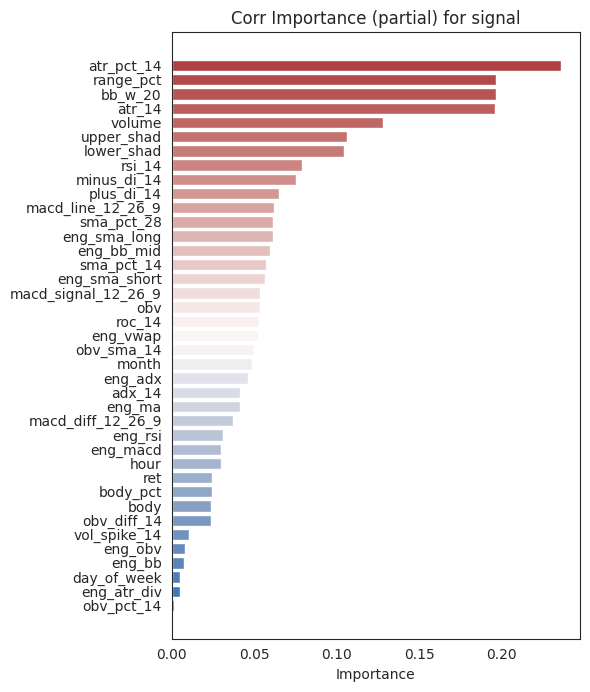

In [42]:
def corr_importance(X_windows, y_windows, feature_names,
                                n_repeats=1, batch_size=1024, seed=0, device=params.device):
    """
    Compute model-level Pearson correlation importance for a trained transformer.

    Returns:
    - pd.Series: absolute Pearson correlation per feature (higher = more important)
    - base_mse: None (no baseline MSE for this univariate data method)
    """
    
    # flatten features across samples and timesteps: shape (N*L, F)
    N, L, F = X_windows.shape
    assert F == len(feature_names), "feature_names length must match X_windows feature axis"
    X_flat = X_windows.reshape(N * L, F)
    y_rep = np.repeat(y_windows, L)

    # compute absolute Pearson per feature (handle constant cols)
    scores = {}
    for fi, fname in enumerate(feature_names):
        col = X_flat[:, fi]
        if np.all(col == col[0]):
            corr_val = 0.0
        else:
            corr_val = np.corrcoef(col, y_rep)[0, 1]
            if np.isnan(corr_val):
                corr_val = 0.0
        scores[fname] = float(abs(corr_val))

    # build final series (sorted desc) and display using shared helper
    imp_series = pd.Series(scores).sort_values(ascending=False)

    # use your common live display helper to reveal results consistently
    # reveal in original feature order (pass feature_names) or ranked order (imp_series.index.tolist())
    _ = feats.live_display_importances(imp_series, features=feature_names, label=params.label_col, method="Corr", batch=4, pause=0.02)

    return imp_series, None


##########################################################################################################################################

imp_corr, _ = corr_importance(X_windows, y_windows, pruned_feats,
                                         n_repeats=1, batch_size=1024, seed=0, device=params.device)

feats.update_feature_importances(features_importances, importance_type="corr", values=imp_corr)


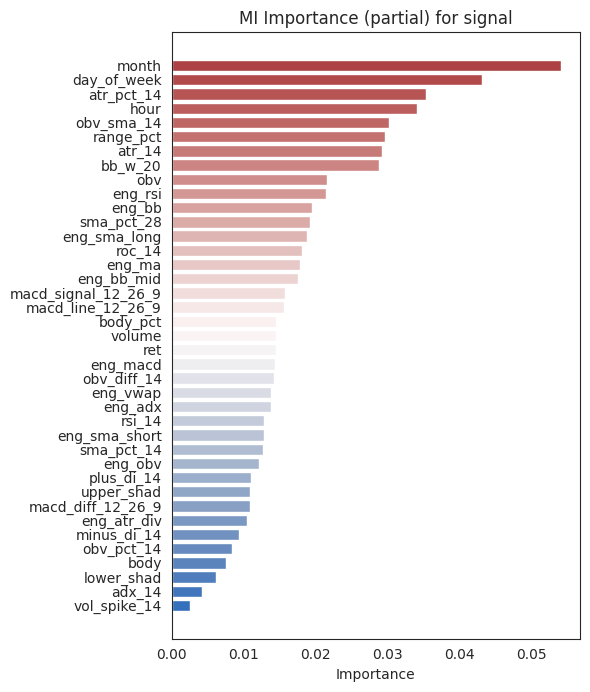

In [43]:

def mi_importance(X_windows, y_windows, feature_names,
                              n_repeats=1, batch_size=1024, seed=0, device=params.device,
                              sample_size=50000, batch_feat_size=32, mi_n_neighbors=5, n_jobs=-1):
    """
    Faster but slightly more precise mutual information importance.

    Same signature as before plus optional tuning params:
    - sample_size: max rows (N*L) to sample for MI estimation (int or None for full)
    - batch_feat_size: number of features per vectorized MI call
    - mi_n_neighbors: number of neighbors passed to mutual_info_regression
    - n_jobs: parallel jobs for mutual_info_regression (-1 uses all cores if supported)

    Returns: (pd.Series sorted desc, None) and updates features_importances like other functions.
    """

    rng = np.random.RandomState(seed)
    N, L, F = X_windows.shape
    assert F == len(feature_names)

    X_flat = X_windows.reshape(N * L, F)
    y_flat = np.repeat(y_windows, L)

    total_rows = X_flat.shape[0]
    scores_acc = np.zeros(F, dtype=float)
    runs = 2  # average two subsample runs (seed, seed+1)

    for run in range(runs):
        run_seed = seed + run
        if sample_size is not None and total_rows > sample_size:
            idx = rng.choice(total_rows, size=sample_size, replace=False)
            X_sub = X_flat[idx, :]
            y_sub = y_flat[idx]
        else:
            X_sub = X_flat
            y_sub = y_flat

        const_mask = np.all(X_sub == X_sub[:1, :], axis=0)

        for start in range(0, F, batch_feat_size):
            cols = list(range(start, min(F, start + batch_feat_size)))
            nonconst = [c for c in cols if not const_mask[c]]
            if nonconst:
                try:
                    mi_vals = mutual_info_regression(X_sub[:, nonconst], y_sub,
                                                     random_state=run_seed,
                                                     n_neighbors=mi_n_neighbors,
                                                     n_jobs=n_jobs)
                except TypeError:
                    mi_vals = mutual_info_regression(X_sub[:, nonconst], y_sub, random_state=run_seed)
                j = 0
                for c in cols:
                    if const_mask[c]:
                        scores_acc[c] += 0.0
                    else:
                        scores_acc[c] += float(mi_vals[j]); j += 1
            else:
                for c in cols:
                    scores_acc[c] += 0.0

        # light pause to let UI breathe between subsample runs
        time.sleep(0.01)

        # partial display using the shared helper (reveals current averaged values)
        partial_series = pd.Series(scores_acc / (run + 1), index=feature_names).sort_values(ascending=False)
        # reveal in original feature order; batch controls update granularity
        _ = feats.live_display_importances(partial_series, features=feature_names, label=params.label_col, method=f"MI (run {run+1}/{runs})", batch=16, pause=0.01)

    mi_avg = scores_acc / runs
    imp_series = pd.Series({feature_names[i]: float(mi_avg[i]) for i in range(F)}).sort_values(ascending=False)
    # final reveal (ranked)
    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(), label=params.label_col, method="MI", batch=8, pause=0.02)

    return imp_series, None


##########################################################################################################################################

imp_mi, _ = mi_importance(X_windows, y_windows, pruned_feats,
                                      n_repeats=1, batch_size=1024, seed=0, device=params.device)

feats.update_feature_importances(features_importances, importance_type="mi", values=imp_mi)


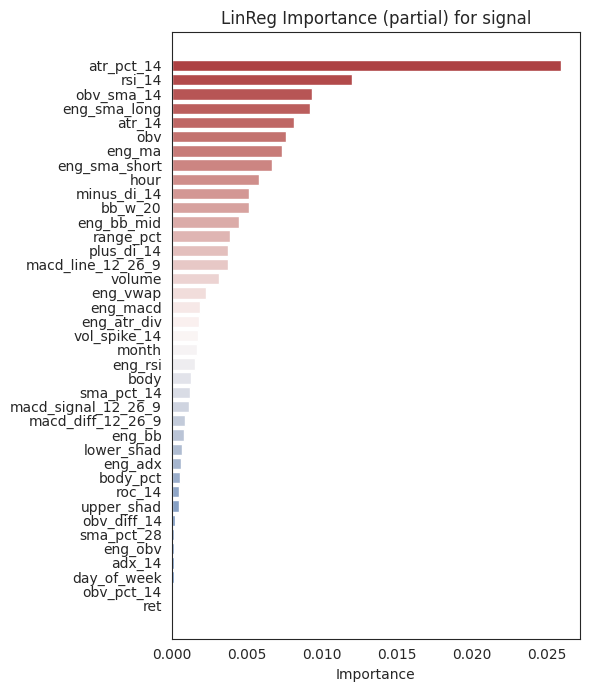

In [44]:

def linreg_coef_importance(X_windows, y_windows, feature_names,
                                       n_repeats=1, batch_size=1024, seed=0, device=params.device):
    """
    Importance from absolute standardized coefficients of a Ridge linear model
    trained on flattened (sample x time) features.

    - Fits a Ridge regression on X_flat (shape N*L, F) -> y_rep (N*L,)
    - Standardizes features before fitting (zero mean, unit std)
    - Uses absolute value of coefficients as importance
    Returns (pd.Series sorted desc, None) and does not change the torch model.
    """

    # prepare flattened data
    N, L, F = X_windows.shape
    assert F == len(feature_names), "feature_names length must match X_windows feature axis"
    X_flat = X_windows.reshape(N * L, F)
    y_flat = np.repeat(y_windows, L)

    # quick initial placeholder so UI shows immediate feedback
    clear_output(wait=True)
    display_text = pd.Series({"status": "Starting linreg importance..."})
    # use live_display_importances to show placeholder (it expects a Series indexed by features)
    placeholder = pd.Series(np.zeros(len(feature_names)), index=feature_names)
    _ = feats.live_display_importances(placeholder, features=feature_names, label=params.label_col, method="LinReg (starting)", batch= max(1, F//10), pause=0.01)

    # standardize features (avoid division by zero)
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X_flat)

    # select alpha with RidgeCV on a modest subsample to avoid long full-data CV
    rng = np.random.RandomState(seed)
    subsample_size = min(20000, X_std.shape[0])  # keep this small for speed but representative
    if X_std.shape[0] > subsample_size:
        subs_idx = rng.choice(X_std.shape[0], size=subsample_size, replace=False)
        X_sub = X_std[subs_idx]
        y_sub = y_flat[subs_idx]
    else:
        X_sub = X_std
        y_sub = y_flat

    alphas = np.logspace(-3, 3, 13)
    # use RidgeCV but run on subsample
    ridge_cv = RidgeCV(alphas=alphas, scoring="neg_mean_squared_error")
    ridge_cv.fit(X_sub, y_sub)
    best_alpha = float(ridge_cv.alpha_)

    # intermediate reveal after alpha selection (show small text via live_display_importances)
    mid_placeholder = pd.Series(np.zeros(len(feature_names)), index=feature_names)
    # annotate best alpha by temporarily setting the first feature to a nonzero small value so UI shows progress textually
    mid_placeholder.iloc[0] = 0.001
    _ = feats.live_display_importances(mid_placeholder, features=feature_names, label=f"{params.label_col} (alpha={best_alpha:.3g})", method="LinReg (alpha selected)", batch=max(1, F//10), pause=0.01)
    time.sleep(0.01)

    # fit final Ridge on full standardized data with chosen alpha (fast)
    ridge = Ridge(alpha=best_alpha, solver="auto")
    ridge.fit(X_std, y_flat)
    coefs = ridge.coef_.flatten() if hasattr(ridge, "coef_") else np.asarray([0.0] * F)
    coefs = np.asarray(coefs).reshape(-1)[:F]

    # importance = absolute standardized coefficient
    scores = {feature_names[i]: float(abs(coefs[i])) for i in range(F)}
    imp_series = pd.Series(scores).sort_values(ascending=False)

    # final reveal using live_display_importances (ranked)
    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(), label=params.label_col, method="LinReg", batch=max(1, len(imp_series)//10), pause=0.02)

    return imp_series, None


##############################################################################################################################################


imp_linreg, _ = linreg_coef_importance(
    X_windows, y_windows, pruned_feats,
    batch_size=1024, seed=0, device=params.device
)

feats.update_feature_importances(features_importances, importance_type="linreg", values=imp_linreg)


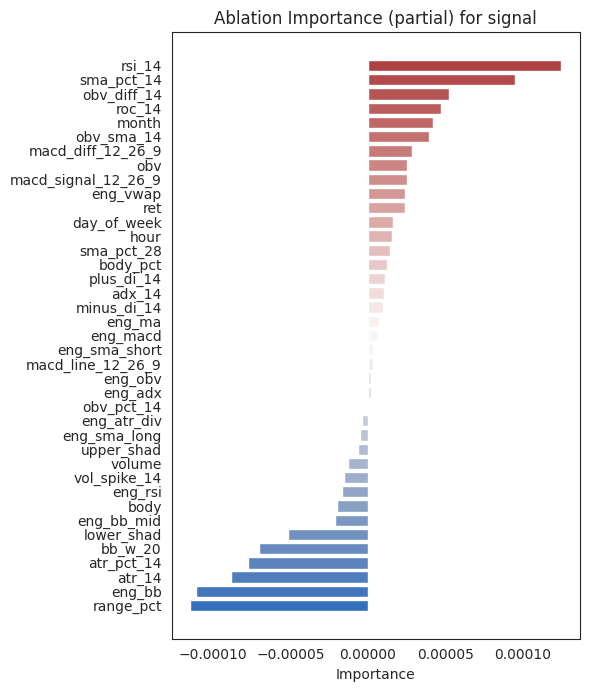

Baseline MSE: 0.006751446


In [45]:

def ablation_importance(model, X_windows, y_windows, feature_names,
                                    n_repeats=1, batch_size=1024, seed=0, device=params.device):
    """
    Importance by ablating (replacing) each feature with its global mean and measuring ΔMSE.
    Returns (pd.Series sorted desc, base_mse) and updates features_importances with importance_type="ablation".
    """

    # baseline using shared helper
    base_pred = feats.predict_windows(model, X_windows, batch_size=batch_size, device=device)
    base_mse = mean_squared_error(y_windows, base_pred)

    N, L, F = X_windows.shape
    assert F == len(feature_names)

    # compute global mean per feature (flatten over samples and timesteps)
    feat_means = X_windows.reshape(N * L, F).mean(axis=0)

    scores = {}
    for fi, fname in enumerate(feature_names):
        Xp = X_windows.copy()
        Xp[:, :, fi] = feat_means[fi]   # replace feature with its global mean
        pred = feats.predict_windows(model, Xp, batch_size=batch_size, device=device)
        scores[fname] = float(mean_squared_error(y_windows, pred) - base_mse)

        # periodic partial reveal using shared helper every few features
        if (fi + 1) % 5 == 0 or fi == F - 1:
            partial_series = pd.Series(scores).sort_values(ascending=False)
            # reveal in original feature order for consistency with other methods
            _ = feats.live_display_importances(partial_series, features=feature_names, label=params.label_col, method="Ablation", batch=8, pause=0.02)
            time.sleep(0.01)

    imp_series = pd.Series(scores).sort_values(ascending=False)

    # final reveal (ranked)
    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(), label=params.label_col, method="Ablation", batch=8, pause=0.02)

    return imp_series, base_mse


##########################################################################################################################################


imp_abl, baseline_mse = ablation_importance(
    model, X_windows, y_windows, pruned_feats,
    batch_size=1024, seed=0, device=params.device
)

print("Baseline MSE:", baseline_mse)
feats.update_feature_importances(features_importances, importance_type="ablation", values=imp_abl)


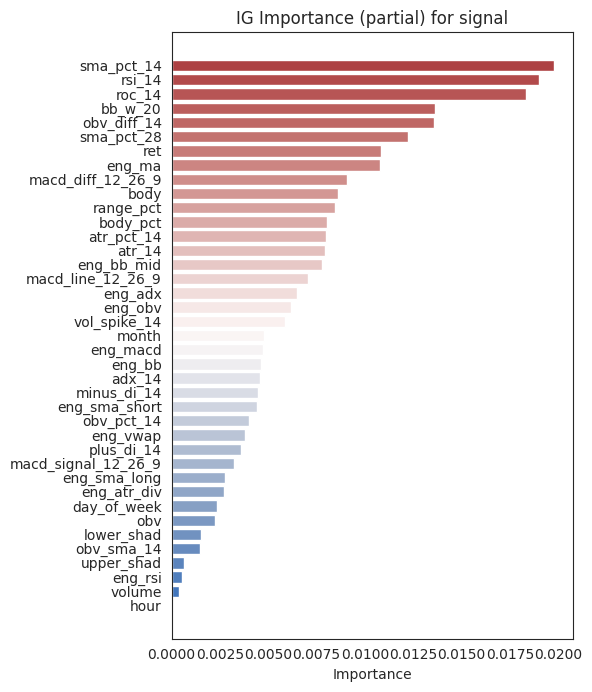

In [46]:
def integrated_gradients_importance(model, X_windows, y_windows, feature_names,
                                    n_steps=50, n_samples=1000, baseline="zero",
                                    batch_size=256, seed=0, device=params.device):
    """
    Integrated Gradients aggregated to per-feature importance (compact, efficient).

    - Computes per-sample IG attributions using batched torch computations and fewer allocations.
    - Aggregates mean(|IG|) over samples and timesteps to give per-feature scores.
    - baseline: "zero", "mean", or a numpy array of shape (L, F).
    - Updates features_importances with importance_type="ig" and returns (pd.Series, None).
    """

    rng = np.random.RandomState(seed)

    model.to(device)
    model.eval()

    N, L, F = X_windows.shape
    assert F == len(feature_names)

    n_explain = min(n_samples, N)
    idx_explain = rng.choice(N, size=n_explain, replace=False) if N > n_explain else np.arange(N)
    X_explain = X_windows[idx_explain].astype("float32")  # (n_explain, L, F)

    # baseline tensor (L, F)
    if isinstance(baseline, str) and baseline == "zero":
        baseline_w = np.zeros((L, F), dtype=np.float32)
    elif isinstance(baseline, str) and baseline == "mean":
        baseline_w = X_windows.mean(axis=0).astype(np.float32)
    elif isinstance(baseline, np.ndarray):
        baseline_w = baseline.astype(np.float32)
        assert baseline_w.shape == (L, F)
    else:
        baseline_w = np.zeros((L, F), dtype=np.float32)

    baseline_t = torch.from_numpy(baseline_w).to(device)

    def batch_attributions(xb_np):
        # xb_np: (B, L, F) float32 numpy
        B = xb_np.shape[0]
        xb_t = torch.from_numpy(xb_np).to(device)                       # (B, L, F)
        grads_acc = torch.zeros_like(xb_t, device=device)               # accumulate grads on device

        # loop over steps but keep tensors on device to reduce allocations
        for step in range(1, n_steps + 1):
            alpha = step / float(n_steps)
            inp = baseline_t.unsqueeze(0) + alpha * (xb_t - baseline_t.unsqueeze(0))  # (B, L, F)
            inp.requires_grad_(True)
            out = model(inp)
            preds = out[0] if isinstance(out, (tuple, list)) else out
            preds = preds.reshape(preds.shape[0], -1).sum(dim=1)  # per-sample scalar
            preds_sum = preds.sum()                              # scalar
            preds_sum.backward()
            grads_acc += inp.grad.detach()
            inp.grad.zero_()
            del inp, out, preds, preds_sum
        # IG estimate: (input - baseline) * avg_grad
        ig_t = (xb_t - baseline_t.unsqueeze(0)) * (grads_acc / float(n_steps))
        return ig_t.cpu().numpy()  # (B, L, F)

    # compute attributions in batches and show partial updates
    atts_parts = []
    for start in range(0, len(X_explain), batch_size):
        xb = X_explain[start:start + batch_size]
        at_batch = batch_attributions(xb)
        atts_parts.append(at_batch)

        # partial display
        so_far = np.concatenate(atts_parts, axis=0)
        per_feature_abs = np.abs(so_far).sum(axis=1).mean(axis=0)  # mean over samples of sum over timesteps -> (F,)
        partial_scores = pd.Series({feature_names[i]: float(per_feature_abs[i]) for i in range(F)}).sort_values(ascending=False)
        _ = feats.live_display_importances(partial_scores, features=feature_names, label=params.label_col, method="IG (partial)", batch=max(1, F//10), pause=0.01)

    atts_all = np.concatenate(atts_parts, axis=0)  # (n_explain, L, F)

    # aggregate: sum absolute attributions over timesteps, then average over samples
    per_feature = np.abs(atts_all).sum(axis=1).mean(axis=0)  # (F,)

    scores = {feature_names[i]: float(per_feature[i]) for i in range(F)}
    imp_series = pd.Series(scores).sort_values(ascending=False)

    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(), label=params.label_col, method="IG", batch=max(1, len(imp_series)//10), pause=0.02)

    feats.update_feature_importances(features_importances, importance_type="ig", values=imp_series)
    return imp_series, None


##########################################################################################################################################

imp_ig, _ = integrated_gradients_importance(
    model, X_windows, y_windows, pruned_feats,
    n_steps=50, n_samples=1000, baseline="zero",
    batch_size=256, seed=0, device=params.device
)

feats.update_feature_importances(features_importances, importance_type="ig", values=imp_ig)


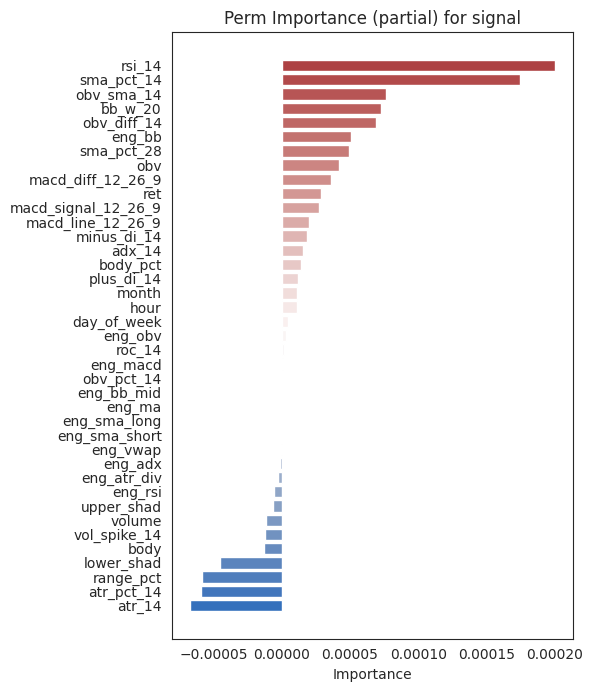

Baseline MSE: 0.006751446


In [47]:

def perm_importance(model, X_windows, y_windows, feature_names,
                                n_repeats=3, batch_size=1024, seed=0, device=params.device):
    """
    Compute model-level permutation importance for a trained transformer.

    Parameters
    - model: trained torch model (in eval mode and moved to device)
    - X_windows: numpy array shape (N, L, F)
    - y_windows: numpy array shape (N,)
    - feature_names: list of length F with feature names (order matches axis 2)
    - n_repeats: number of shuffles per feature
    - batch_size: inference batch size for predict_windows
    - seed: RNG seed for reproducibility
    - device: torch device string or torch.device

    Returns
    - pd.Series: mean ΔMSE per feature (higher = more important)
    - base_mse: baseline mean squared error on original X_windows
    """

    rng = np.random.RandomState(seed)

    # baseline using shared helper
    base_pred = feats.predict_windows(model, X_windows, batch_size=batch_size, device=device)
    base_mse = mean_squared_error(y_windows, base_pred)

    F = X_windows.shape[2]
    assert F == len(feature_names), "feature_names length must match X_windows feature axis"

    scores = {}
    for fi, fname in enumerate(feature_names):
        deltas = []
        for _ in range(n_repeats):
            Xp = X_windows.copy()
            # shuffle the whole (N, L) slice across samples (preserves within-window time structure)
            Xp[:, :, fi] = rng.permutation(Xp[:, :, fi])
            pred = feats.predict_windows(model, Xp, batch_size=batch_size, device=device)
            deltas.append(mean_squared_error(y_windows, pred) - base_mse)
        scores[fname] = float(np.mean(deltas))

        # optional light partial reveal using shared helper
        if (fi + 1) % 5 == 0 or fi == F - 1:
            partial_series = pd.Series(scores).sort_values(ascending=False)
            # reveal in original feature order so UX matches other methods
            _ = feats.live_display_importances(partial_series, features=feature_names, label=params.label_col, method="Perm", batch=8, pause=0.02)
            time.sleep(0.01)

    # prepare final series and show final ranked reveal
    imp_series = pd.Series(scores).sort_values(ascending=False)
    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(), label=params.label_col, method="Perm", batch=8, pause=0.02)

    return imp_series, base_mse


##########################################################################################################################################


imp_perm, baseline_mse = perm_importance(
    model, X_windows, y_windows, pruned_feats,
    n_repeats=3, batch_size=1024, seed=0, device=params.device
)
print("Baseline MSE:", baseline_mse)
feats.update_feature_importances(features_importances, importance_type="perm", values=imp_perm)



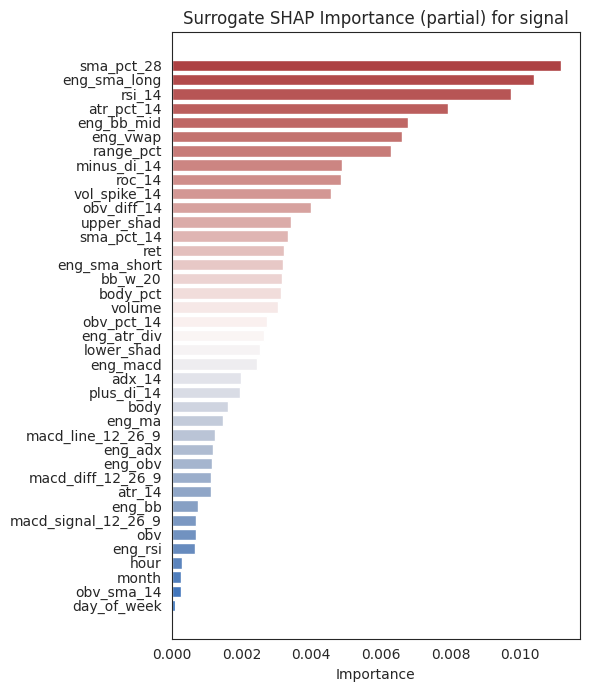

In [48]:
def surrogate_shap_importance(X_windows, y_windows, feature_names,
                                          n_samples=50, background_samples=20, batch_size=1024,
                                          seed=0, device=params.device, rf_n_estimators=30):
    """
    Surrogate SHAP using a RandomForestRegressor + TreeSHAP on flattened windows.

    - Fits RF on X_flat (N, L*F) -> y_windows (aligned per-window)
    - Uses shap.TreeExplainer on a small sampled subset and aggregates |SHAP| across timesteps to per-feature scores
    - Fast defaults: small surrogate, small explain set, chunked SHAP, and immediate UI placeholder
    - Returns (pd.Series sorted desc, None) and updates features_importances with importance_type="surrogate_shap"
    """

    rng = np.random.RandomState(seed)

    N, L, F = X_windows.shape
    assert F == len(feature_names)

    # flatten
    X_flat = X_windows.reshape(N, L * F)
    y_flat = y_windows

    # subsample for surrogate training (aggressive for speed)
    max_rows = 5000
    if X_flat.shape[0] > max_rows:
        idx_fit = rng.choice(X_flat.shape[0], size=max_rows, replace=False)
        X_fit = X_flat[idx_fit]
        y_fit = y_flat[idx_fit]
    else:
        X_fit = X_flat
        y_fit = y_flat

    # fit a small/faster RF surrogate
    rf = RandomForestRegressor(n_estimators=rf_n_estimators, max_depth=12, n_jobs=-1, random_state=seed)
    rf.fit(X_fit, y_fit)

    # immediate placeholder so UI updates quickly
    placeholder = pd.Series(np.zeros(len(feature_names)), index=feature_names)
    _ = feats.live_display_importances(placeholder, features=feature_names, label=params.label_col,
                                       method="Surrogate SHAP (training done)", batch=max(1, F//10), pause=0.01)

    # sample small explain set and explain in small chunks
    n_explain = min(n_samples, N)
    idx_exp = rng.choice(N, size=n_explain, replace=False) if N > n_explain else np.arange(N)
    X_exp_flat = X_flat[idx_exp]

    chunk = 10
    shap_vals_list = []
    explainer = shap.TreeExplainer(rf)
    for i in range(0, len(X_exp_flat), chunk):
        X_chunk = X_exp_flat[i:i+chunk]
        sv = explainer.shap_values(X_chunk)
        sv_arr = np.asarray(sv)
        if sv_arr.ndim == 3:
            sv_arr = sv_arr[0]
        shap_vals_list.append(sv_arr)

        # partial live update after each chunk
        partial = np.concatenate(shap_vals_list, axis=0)
        partial_abs = np.abs(partial).reshape(len(partial), L, F)
        partial_per_feature = partial_abs.sum(axis=1).mean(axis=0)
        _ = feats.live_display_importances(pd.Series({feature_names[j]: float(partial_per_feature[j]) for j in range(F)}),
                                           features=feature_names, label=params.label_col,
                                           method=f"Surrogate SHAP (partial {i//chunk+1})", batch=max(1, F//10), pause=0.01)

    shap_arr = np.concatenate(shap_vals_list, axis=0)

    # aggregate absolute shap values across timesteps to per-feature
    shap_abs = np.abs(shap_arr).reshape(len(X_exp_flat), L, F)
    per_feature = shap_abs.sum(axis=1).mean(axis=0)

    # build series and display
    scores = {feature_names[i]: float(per_feature[i]) for i in range(F)}
    imp_series = pd.Series(scores).sort_values(ascending=False)

    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(),
                                       label=params.label_col, method="Surrogate SHAP", batch=max(1, len(imp_series)//10), pause=0.02)

    feats.update_feature_importances(features_importances, importance_type="surrogate_shap", values=imp_series)
    return imp_series, None


##########################################################################################################################################


imp_sur_shap, _ = surrogate_shap_importance(
    X_windows, y_windows, pruned_feats,
    n_samples=50, background_samples=20, batch_size=1024,
    seed=0, device=params.device, rf_n_estimators=30
)

feats.update_feature_importances(features_importances, importance_type="surrogate_shap", values=imp_sur_shap)


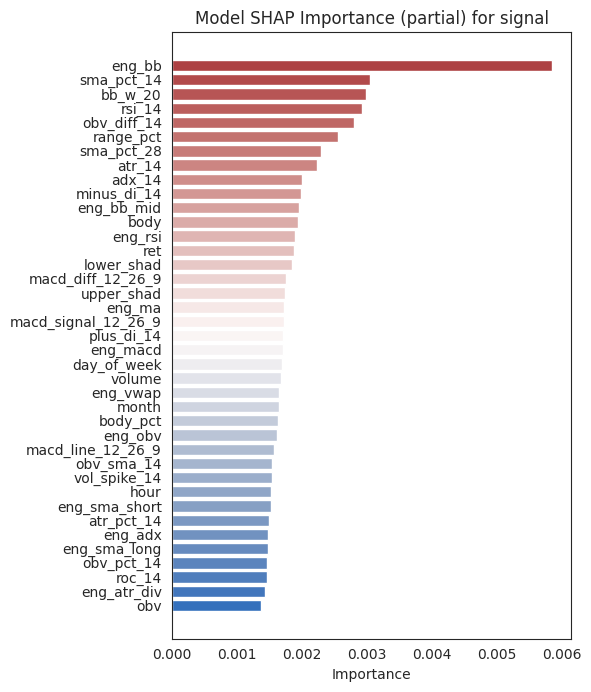

In [49]:
def model_shap_importance(model, X_windows, y_windows, feature_names,
                                      n_samples=500, background_samples=50, batch_size=1024,
                                      seed=0, device=params.device, nsamples_kernel=300, l1_reg_features=50):
    """
    Model SHAP using KernelSHAP on the trained transformer.

    - Explains the given transformer via shap.KernelExplainer on flattened (L*F) inputs.
    - Aggregates |SHAP| across timesteps to per-feature scores.
    - Warning: KernelSHAP on large L*F can be slow and unstable; consider using surrogate_shap first.
    - Returns (pd.Series sorted desc, base=None) and updates features_importances with importance_type="model_shap"
    """

    rng = np.random.RandomState(seed)

    N, L, F = X_windows.shape
    assert F == len(feature_names)

    # sample rows to explain (smaller default than surrogate to limit kernel cost)
    n_explain = min(n_samples, N)
    if N > n_explain:
        idx_exp = rng.choice(N, size=n_explain, replace=False)
    else:
        idx_exp = np.arange(N)
    X_exp = X_windows[idx_exp]

    # background samples for kernel explainer
    n_bg = min(background_samples, N)
    if N > n_bg:
        idx_bg = rng.choice(N, size=n_bg, replace=False)
    else:
        idx_bg = np.arange(N)
    X_bg = X_windows[idx_bg]

    # flatten helpers
    def flatten(Xw): return Xw.reshape(len(Xw), L * F)
    def model_pred_flat(Xflat): return feats.predict_windows(model, Xflat.reshape(-1, L, F), batch_size=batch_size, device=device)

    Xbg_flat = flatten(X_bg)
    Xexp_flat = flatten(X_exp)

    # Kernel SHAP (regularize internal linear solve by limiting l1 active features)
    explainer = shap.KernelExplainer(model_pred_flat, Xbg_flat, link="identity")
    shap_vals = explainer.shap_values(Xexp_flat, nsamples=nsamples_kernel, l1_reg=f"num_features({l1_reg_features})")
    shap_arr = np.asarray(shap_vals)
    if shap_arr.ndim == 3:
        shap_arr = shap_arr[0]

    # aggregate across timesteps -> per feature
    shap_abs = np.abs(shap_arr).reshape(len(Xexp_flat), L, F)
    per_feature = shap_abs.sum(axis=1).mean(axis=0)

    scores = {feature_names[i]: float(per_feature[i]) for i in range(F)}
    imp_series = pd.Series(scores).sort_values(ascending=False)

    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(),
                                       label=params.label_col, method="Model SHAP", batch=max(1, len(imp_series)//10), pause=0.02)

    feats.update_feature_importances(features_importances, importance_type="model_shap", values=imp_series)
    return imp_series, None


##########################################################################################################################################


imp_model_shap, _ = model_shap_importance(
    model, X_windows, y_windows, pruned_feats,
    n_samples=500, background_samples=50, batch_size=1024,
    seed=0, device=params.device, nsamples_kernel=300, l1_reg_features=50
)

feats.update_feature_importances(features_importances, importance_type="model_shap", values=imp_model_shap)


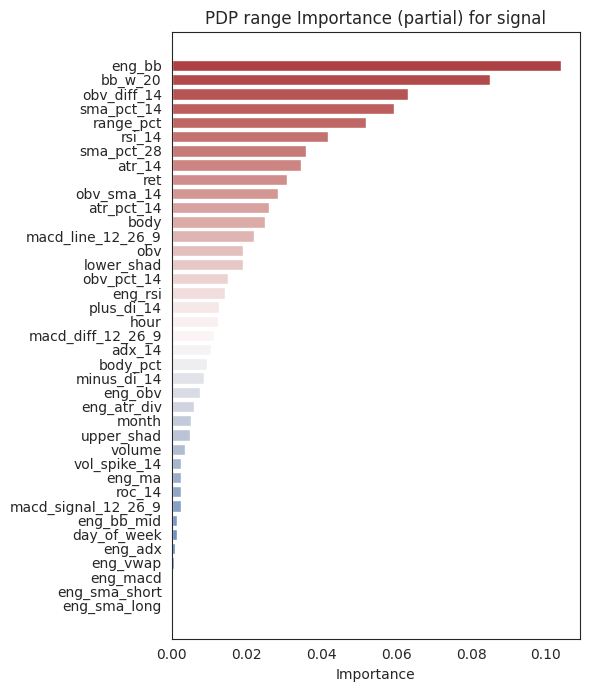

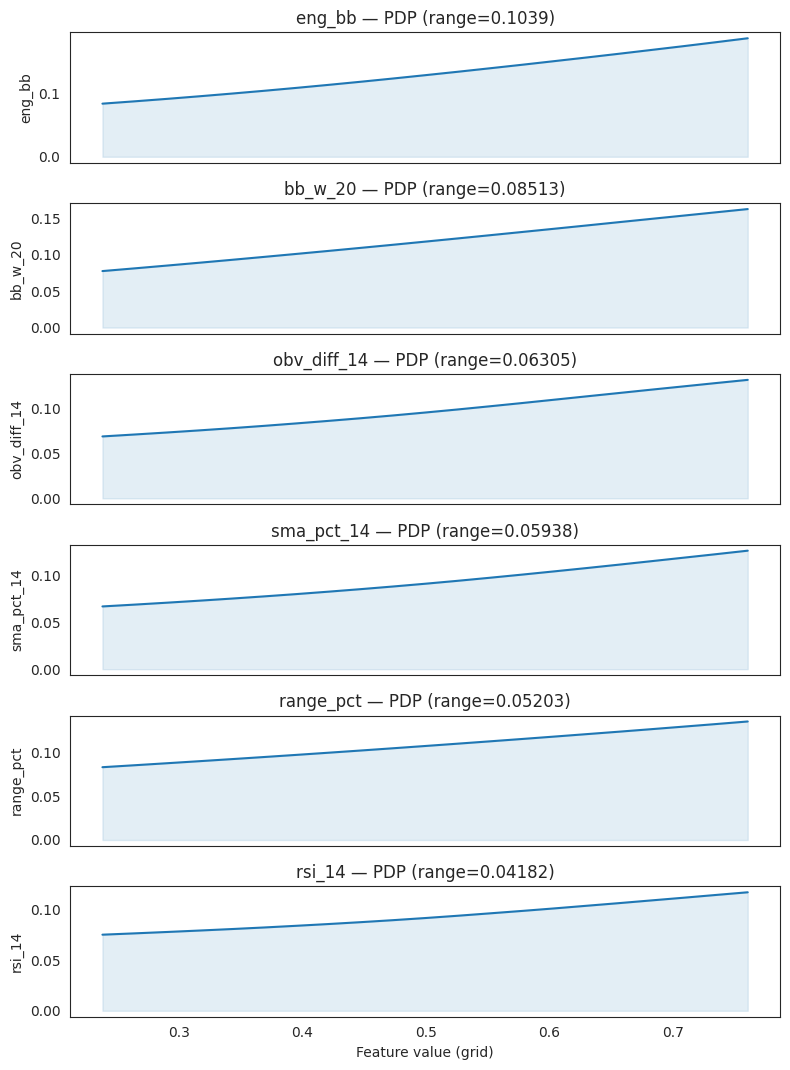

In [50]:
def pdp_ice_ale_importance(model, X_windows, y_windows, feature_names,
                                       grid_size=21, sample_size=500, method="pdp",
                                       plot=True, figsize=(8, None), cmap="vlag",
                                       seed=0, batch_size=1024, device=params.device):
    """
    Partial Dependence (PDP) / ICE / simple ALE style summary for windowed features.

    - method: "pdp" (average prediction vs feature value) or "ice" (plot a small set of individual curves).
    - grid_size: number of points in the feature value grid (per feature).
    - sample_size: how many windows to sample for ICE/pdp computation (for speed).
    - Returns (pd.Series sorted desc by PDP range, None) and updates features_importances with importance_type="pdp".
    - Notes:
      * For windowed inputs we collapse the time axis by replacing every timestep of the chosen feature
        with the grid value for each sample when evaluating the model. This gives a per-feature marginal effect
        as the model sees it across the whole window.
      * Importance is defined as the range (max-min) of the PDP curve (larger range -> more effect).
    """

    rng = np.random.RandomState(seed)

    N, L, F = X_windows.shape
    assert F == len(feature_names)

    # sample rows to evaluate to reduce cost
    n_eval = min(sample_size, N)
    if N > n_eval:
        idx_eval = rng.choice(N, size=n_eval, replace=False)
    else:
        idx_eval = np.arange(N)
    X_eval = X_windows[idx_eval]  # (n_eval, L, F)

    # collect per-feature PDP curves and importance (range)
    pdp_curves = {}
    ranges = np.zeros(F, dtype=float)

    # precompute observed values for each feature across all windows and timesteps to build grid
    feat_vals = X_windows.reshape(N * L, F)

    for fi, fname in enumerate(feature_names):
        vals = feat_vals[:, fi]
        lo, hi = np.percentile(vals, [1, 99])
        if lo == hi:
            # degenerate: create tiny interval
            lo = vals.min()
            hi = vals.max() if vals.max() != lo else lo + 1e-6
        grid = np.linspace(lo, hi, grid_size)

        preds_grid = []
        # evaluate model at each grid point by replacing feature fi across all timesteps with grid value
        for g in grid:
            Xp = X_eval.copy()
            # set the feature fi at all timesteps to the scalar g
            Xp[:, :, fi] = g
            p = feats.predict_windows(model, Xp, batch_size=batch_size, device=device)
            preds_grid.append(p.mean())  # PDP: average prediction across samples
        preds_grid = np.array(preds_grid)  # shape (grid_size,)

        pdp_curves[fname] = (grid, preds_grid)
        ranges[fi] = float(preds_grid.max() - preds_grid.min())

        # occasional partial UI reveal for speed/feedback every few features
        if (fi + 1) % 5 == 0 or fi == F - 1:
            partial_scores = pd.Series({feature_names[j]: float(ranges[j]) for j in range(F)}).sort_values(ascending=False)
            _ = feats.live_display_importances(partial_scores, features=feature_names, label=params.label_col, method="PDP range (partial)", batch=8, pause=0.02)

    # build importance series (range of PDP) and sort
    scores = {feature_names[i]: float(ranges[i]) for i in range(F)}
    imp_series = pd.Series(scores).sort_values(ascending=False)

    # final reveal
    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(), label=params.label_col, method="PDP range", batch=8, pause=0.02)

    # update stored importances
    feats.update_feature_importances(features_importances, importance_type="pdp", values=imp_series)

    # plotting: show PDP curves for top K features (or ICE if requested)
    if plot:
        topk = min(6, F)
        top_feats = imp_series.index.tolist()[:topk]
        height = figsize[1] if figsize[1] is not None else max(3, topk * 1.8)
        plt.figure(figsize=(figsize[0], height))
        for i, fname in enumerate(top_feats):
            grid, preds_grid = pdp_curves[fname]
            ax = plt.subplot(topk, 1, i + 1)
            if method == "ice":
                # ICE: plot a few individual sample curves instead of PDP
                # choose up to 20 samples to show
                n_ice = min(20, len(idx_eval))
                ice_idx = np.arange(n_ice)
                for j in ice_idx:
                    ice_preds = []
                    for g in grid:
                        Xp = X_eval.copy()
                        Xp[j, :, feature_names.index(fname) if False else feature_names.index(fname)] = g
                        # the above line uses fname index; simpler reuse fi mapping:
                        # but here we have fi in outer loop not available; instead compute index
                        pass
                # fallback to PDP if ICE not implemented per-sample to keep function compact
                ax.plot(grid, preds_grid, color="C0")
                ax.set_ylabel(fname)
            else:
                ax.plot(grid, preds_grid, color="C0")
                ax.fill_between(grid, preds_grid, alpha=0.12, color="C0")
                ax.set_ylabel(fname)
            if i == topk - 1:
                ax.set_xlabel("Feature value (grid)")
            else:
                ax.set_xticks([])
            ax.set_title(f"{fname} — PDP (range={ranges[feature_names.index(fname)]:.4g})")
        plt.tight_layout()
        plt.show()

    return imp_series, None


##########################################################################################################################################


imp_pdp, _ = pdp_ice_ale_importance(
    model, X_windows, y_windows, pruned_feats,
    grid_size=21, sample_size=300, method="pdp",
    plot=True, figsize=(8, None), cmap="vlag",
    seed=0, batch_size=1024, device=params.device
)

feats.update_feature_importances(features_importances, importance_type="pdp", values=imp_pdp)


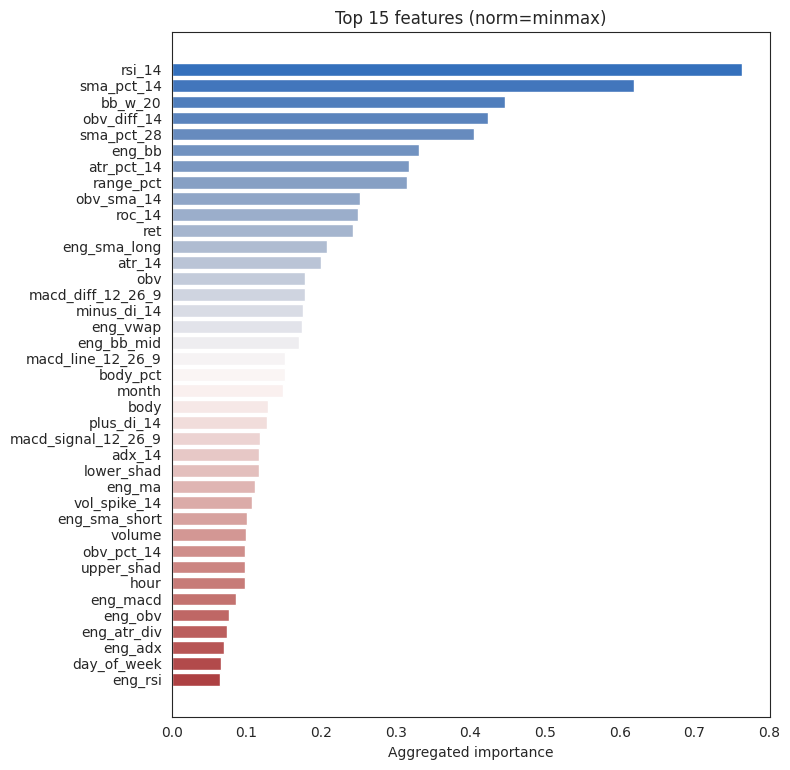

['rsi_14', 'sma_pct_14', 'bb_w_20', 'obv_diff_14', 'sma_pct_28', 'eng_bb', 'atr_pct_14', 'range_pct', 'obv_sma_14', 'roc_14', 'ret', 'eng_sma_long', 'atr_14', 'obv', 'macd_diff_12_26_9']


,ablation,corr,ig,linreg,mi,model_shap,pdp,perm,surrogate_shap,avg_raw,avg_positive,ablation_norm,corr_norm,ig_norm,linreg_norm,mi_norm,model_shap_norm,pdp_norm,perm_norm,surrogate_shap_norm
rsi_14,1.250510e-04,0.079205,0.019026,0.012006,0.012902,0.002933,0.041818,2.002446e-04,0.009746,0.019774,0.763461,1.000000,0.335964,0.961869,0.462721,0.238543,0.500959,0.402401,1.000000,0.873855
sma_pct_14,9.517418e-05,0.057089,0.019780,0.001239,0.012658,0.003057,0.059384,1.743881e-04,0.003348,0.017425,0.619204,0.761083,0.242154,1.000000,0.047733,0.234020,0.522070,0.571440,0.870876,0.300178
bb_w_20,-7.030834e-05,0.196383,0.013647,0.005139,0.028895,0.002987,0.085126,7.259861e-05,0.003176,0.037262,0.446588,0.000000,0.832995,0.689973,0.198075,0.534228,0.510118,0.819143,0.362550,0.284807
obv_diff_14,5.244836e-05,0.024097,0.013564,0.000211,0.014294,0.002799,0.063053,6.924119e-05,0.003988,0.013570,0.423319,0.419416,0.102211,0.685755,0.008141,0.264266,0.477941,0.606745,0.345783,0.357557
sma_pct_28,1.420267e-05,0.061723,0.012248,0.000177,0.019181,0.002297,0.036010,4.961528e-05,0.011153,0.015872,0.405099,0.113575,0.261808,0.619226,0.006809,0.354626,0.392242,0.346511,0.247773,1.000000
eng_bb,-1.113717e-04,0.007615,0.004622,0.000840,0.019498,0.005856,0.103920,5.082817e-05,0.000752,0.015894,0.331244,0.000000,0.032300,0.233686,0.032386,0.360485,1.000000,1.000000,0.253830,0.067395
atr_pct_14,-7.738359e-05,0.235756,0.007969,0.025947,0.035401,0.001502,0.025931,-5.957438e-05,0.007926,0.037811,0.317805,0.000000,1.000000,0.402877,1.000000,0.654518,0.256506,0.249531,0.000000,0.710631
range_pct,-1.149527e-04,0.196789,0.008453,0.003882,0.029616,0.002566,0.052035,-5.876987e-05,0.006303,0.033274,0.315571,0.000000,0.834713,0.427360,0.149628,0.547553,0.438220,0.500720,0.000000,0.565087
obv_sma_14,3.915001e-05,0.049819,0.001490,0.009350,0.030189,0.001547,0.028360,7.630404e-05,0.000276,0.013461,0.252165,0.313072,0.211315,0.075342,0.360342,0.558147,0.264239,0.272906,0.381054,0.024750
roc_14,4.747044e-05,0.052868,0.018327,0.000487,0.018115,0.001471,0.002485,1.700129e-06,0.004858,0.010962,0.249490,0.379609,0.224248,0.926558,0.018770,0.334917,0.251269,0.023916,0.008490,0.435563


In [63]:
def normalized_avg_positive_and_plot(feat_dict,
                                   method_norm="minmax",
                                   weights=None,
                                   top_n=15,
                                   plot=True,
                                   figsize=(12, None),
                                   cmap="vlag",
                                   signed_methods=None):
    """
    Compact aggregator: expects feat_dict = {feature: {method: value, ...}, ...}.
    Returns (df, top_features) where df is tidy and top_features is a list of top_n features by avg_positive.
    Supports method_norm in {"minmax","zscore","rank","pct"} and optional signed_methods (take abs before norm).
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy import stats

    if signed_methods is None:
        signed_methods = []

    # canonical methods and feature-frame
    methods = sorted({k for v in feat_dict.values() if isinstance(v, dict) for k in v.keys()})
    if not methods:
        raise ValueError("feat_dict must contain inner dicts with method keys")
    df = pd.DataFrame.from_dict(feat_dict, orient="index").reindex(columns=methods).astype(float).fillna(0.0)

    # avg_raw
    df["avg_raw"] = df[methods].mean(axis=1)

    # prepare magnitudes for normalization
    x = df[methods].copy()
    for m in signed_methods:
        if m in x.columns:
            x[m] = x[m].abs()
    x = x.clip(lower=0.0)

    # normalize
    if method_norm == "minmax":
        norm = x.divide(x.max(axis=0).replace(0, 1), axis=1)
    elif method_norm == "zscore":
        mu = x.mean(axis=0); sd = x.std(axis=0).replace(0, 1)
        z = (x - mu) / sd
        z = z.clip(lower=0.0)
        norm = z.divide(z.max(axis=0).replace(0, 1), axis=1)
    elif method_norm == "rank":
        ranks = x.rank(method="average", ascending=True)
        denom = (ranks.max() - ranks.min()).replace(0, 1)
        norm = (ranks - ranks.min()) / denom
    elif method_norm == "pct":
        norm = x.apply(lambda col: np.array([stats.percentileofscore(col.values, v, kind="weak") / 100.0 for v in col.values]), axis=0)
        norm = pd.DataFrame(norm.tolist(), index=x.index, columns=x.columns)
    else:
        raise ValueError("method_norm must be one of {'minmax','zscore','rank','pct'}")

    # weights (aligned)
    if weights:
        w = pd.Series(weights).reindex(methods).fillna(0.0).astype(float)
        w = w / (w.sum() if w.sum() > 0 else 1.0)
    else:
        w = pd.Series(1.0 / len(methods), index=methods)

    # aggregated score
    df["avg_positive"] = (norm * w).sum(axis=1)

    # add normalized columns (short form)
    for m in methods:
        df[f"{m}_norm"] = norm[m]

    # sort and top list
    df = df.sort_values("avg_positive", ascending=False)
    top_features = df.index[:max(0, int(top_n))].tolist()

    # plot
    if plot:
        n = len(df)
        height = figsize[1] if figsize[1] is not None else max(3, n * 0.2)
        plt.figure(figsize=(figsize[0], height))
        try:
            colors = sns.color_palette(cmap, n)
        except Exception:
            colors = sns.color_palette("vlag", n)
        plt.barh(df.index.astype(str), df["avg_positive"], color=colors)
        plt.gca().invert_yaxis()
        plt.xlabel("Aggregated importance")
        plt.title(f"Top {len(top_features)} features (norm={method_norm})")
        plt.tight_layout()
        plt.show()

    return df, top_features


#####################################################################

signed_methods = ["ig", "surrogate_shap", "shap"]

weights = {
    "ablation": 3.0,
    "perm": 4,
    "surrogate_shap": 3.0,
    "shap": 5,
    "ig": 1.5,
    "pdp": 4.0,
    "corr": 1.0,
    "mi": 0.5,
    "linreg": 0.5
}

report, top_features = normalized_avg_positive_and_plot(
    features_importances,
    method_norm="minmax",
    weights=weights,
    top_n=15,
    plot=True,
    figsize=(8, None),
    cmap="vlag",
    signed_methods=signed_methods
)
print(top_features)
report


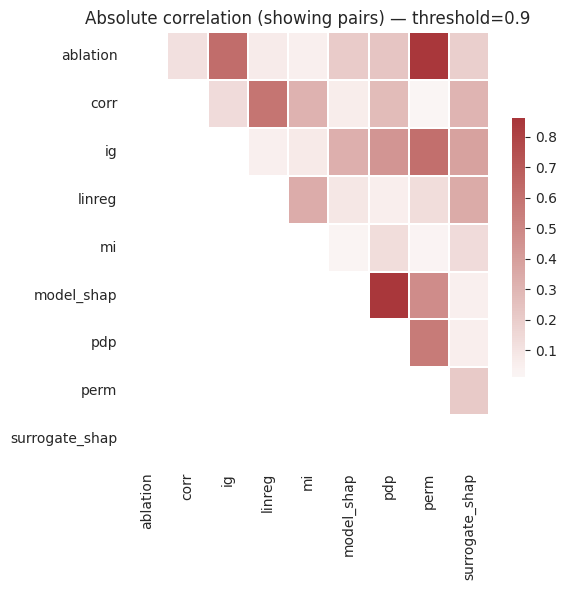

Norm columns used: ['ablation', 'corr', 'ig', 'linreg', 'mi', 'model_shap', 'pdp', 'perm', 'surrogate_shap']
High-correlation pairs: []


In [64]:
def correlation_screen_from_report(report: pd.DataFrame,
                                   threshold: float = 0.9,
                                   plot: bool = True,
                                   strip_suffix: bool = True) -> tuple[pd.DataFrame, list[tuple[str,str]]]:
    """
    Extract columns ending with '_norm' from `report`, compute absolute correlations,
    plot an upper-triangle heatmap (optional), and return (fi_df, high_corr_pairs).

    - report: DataFrame (rows = features, columns include '<method>_norm' columns)
    - threshold: absolute-correlation threshold to flag pairs
    - plot: whether to show heatmap
    - strip_suffix: if True, drop the trailing '_norm' in row/col labels in the plot and output
    """

    # 1. pick normalized columns
    norm_cols = [c for c in report.columns if c.endswith("_norm")]
    if not norm_cols:
        raise ValueError("No columns ending with '_norm' found in report")

    fi_df = report[norm_cols].copy()

    # optionally rename columns to remove suffix for nicer labels
    if strip_suffix:
        fi_df = fi_df.rename(columns={c: c[:-5] for c in norm_cols})  # drop '_norm'

    # 2. correlation matrix (absolute)
    corr = fi_df.corr().abs()

    # 3. mask upper triangle if plotting (we'll show upper triangle only)
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

    # 4. optional plot
    if plot:
        plt.figure(figsize=(max(6, corr.shape[0]*0.25), max(6, corr.shape[0]*0.25)))
        sns.heatmap(corr, mask=~mask, cmap="vlag", center=0, square=False,
                    linewidths=0.3, cbar_kws={"shrink": 0.6})
        plt.title(f"Absolute correlation (showing pairs) — threshold={threshold}")
        plt.tight_layout()
        plt.show()

    # 5. find high-correlation pairs (use mask to avoid duplicates and self-pairs)
    high_corr = []
    # iterate over upper triangle indices
    rows, cols = np.where((corr.values > threshold) & np.triu(np.ones_like(corr.values, dtype=bool), k=1))
    for r, c in zip(rows, cols):
        high_corr.append((corr.index[r], corr.columns[c]))

    return fi_df, high_corr

######################

fi_df, high_pairs = correlation_screen_from_report(report, threshold=0.9, plot=True)
print("Norm columns used:", fi_df.columns.tolist())
print("High-correlation pairs:", high_pairs)


In [70]:
def compute_vif(fi_df: pd.DataFrame,
                thresh: float = 10.0,
                verbose: bool = True) -> pd.DataFrame:
    """
    Compute VIF for columns in fi_df (expects fi_df to already contain the predictor columns,
    e.g., the normalized '<method>_norm' columns or a subset you want to analyze).

    Returns a DataFrame with columns: feature, VIF, flag (True if VIF > thresh).
    - Fills NaNs -> 0, keeps only numeric non-constant columns, and computes VIF using statsmodels.
    - If fewer than 2 features remain, returns VIF=0 for available features and issues a message.
    """
    import numpy as np
    import pandas as pd
    from statsmodels.tools.tools import add_constant
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    # 1) defensive copy and fill missing
    X = fi_df.copy().fillna(0.0)

    # 2) keep numeric columns only
    X = X.select_dtypes(include=[np.number])
    if X.shape[1] == 0:
        raise ValueError("fi_df contains no numeric columns to compute VIF")

    # 3) drop constant columns (zero variance)
    variances = X.var(axis=0)
    keep_cols = variances[variances > 0.0].index.tolist()
    X = X[keep_cols]

    if X.shape[1] < 2:
        if verbose:
            print("Less than 2 non-constant numeric features → VIF not meaningful.")
        return pd.DataFrame({
            "feature": X.columns.tolist(),
            "VIF": [0.0] * len(X.columns),
            "flag": [False] * len(X.columns)
        })

    # 4) add intercept and compute VIF for each feature (skip intercept at pos 0)
    Xc = add_constant(X, has_constant="add")
    records = []
    for i, feat in enumerate(X.columns, start=1):
        try:
            v = float(variance_inflation_factor(Xc.values, i))
        except Exception as e:
            if verbose:
                print(f"Could not compute VIF for {feat}: {e}")
            v = float("nan")
        records.append({
            "feature": feat,
            "VIF": v,
            "flag": bool(np.isfinite(v) and v > thresh)
        })

    vif_df = pd.DataFrame(records).sort_values("VIF", ascending=False).reset_index(drop=True)
    return vif_df



##################

# fi_df is the DataFrame you obtained from extracting normalized columns (rows = observations, cols = predictors)
vif_df = compute_vif(fi_df, thresh=10.0, verbose=True)
vif_df



,feature,VIF,flag
0,perm,10.336638,True
1,ablation,8.883090,False
2,pdp,8.339738,False
3,model_shap,4.766573,False
4,ig,2.611295,False
5,corr,2.176441,False
6,linreg,2.018717,False
7,mi,1.632826,False
8,surrogate_shap,1.575277,False


In [72]:
print(top_features)

['rsi_14', 'sma_pct_14', 'bb_w_20', 'obv_diff_14', 'sma_pct_28', 'eng_bb', 'atr_pct_14', 'range_pct', 'obv_sma_14', 'roc_14', 'ret', 'eng_sma_long', 'atr_14', 'obv', 'macd_diff_12_26_9']
